In [1]:
from itertools import islice
import pandas as pd
import numpy as np
from scipy import stats
from  qgrid import show_grid as show 
import plotly.express as px
import math
import seaborn as sns
from matplotlib import pyplot as plt 
import matplotlib as mpl
from matplotlib.lines import Line2D 
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend ='matplotlib'

mpl.rcParams['boxplot.boxprops.color'] ='white'
mpl.rcParams['boxplot.boxprops.linewidth']=2
mpl.rcParams['patch.edgecolor']='k'
mpl.rcParams['boxplot.patchartist']= "True"
mpl.rcParams['boxplot.flierprops.marker'] = 'o'
mpl.rcParams['boxplot.flierprops.color'] = 'k'
mpl.rcParams['boxplot.flierprops.markerfacecolor'] = "white"
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 
mpl.rcParams['text.usetex'] = True

In [2]:

def parse_log(file_name):

    def slice_log(lines,i,offset=14):
        l=list(islice(lines,i*offset,(i+1)*offset))
        x={}
        x["jvm"],x["mode"],x["benchmark"],x["iteration"]=l[1].strip().split("_")
        x['iteration']=int(x['iteration'])
        x["energy_pkg"]=float(l[7].strip().split(" ")[0].replace(",",""))
        x["energy_core"]=float(l[8].strip().split(" ")[0].replace(",",""))
        x["energy_dram"]=float(l[9].strip().split(" ")[0].replace(",",""))
        x["execution_time"]=float(l[12].strip().split(" ")[0].replace(",",""))
        x["av_power_pkg"]=x["energy_pkg"]/x["execution_time"]
        return x
    
    with open(file_name,'r') as f :
        x=f.readline()
        offset=1
        for line in f.readlines(): 
            if line == x : 
                break 
            offset=offset+1
        f.seek(0)
        lines = f.readlines()
        limit=len(lines)//offset
        l=[slice_log(lines,i,offset) for i in range(0,limit)]
        data=pd.DataFrame(l)
        return data
    

In [3]:
gc_renaissance="report-gc-renaissance-chetemi-3.logs"
gc_dacapo="report-gcdacapo-gc-chetemi-4.logs"
jit_file="report-jit1-chetemi-2.logs"


In [4]:
jit=parse_log(jit_file)
jit=jit.groupby(["jvm","mode","benchmark"]).mean().reset_index()
jit.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg').to_latex(buf="../../table-jit.tex",index=True,float_format="%.2f")
show(jit)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
gc=parse_log(gc_renaissance)
gc=gc.groupby(["jvm","mode","benchmark"]).mean().reset_index()
gc.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg').to_latex(buf="../../table-gc.tex",index=True,float_format="%.2f")
show(gc)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
gc=parse_log(gc_renaissance)
gc=gc.groupby(["jvm","mode","benchmark"]).mean().reset_index()
gc=gc.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg')

In [54]:
show(gc)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [87]:

# x=dacapo.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg')
# x.to_latex(buf="../../table-gc-dacapo.tex",index=True,float_format="%.2f")

In [77]:
show(dacapo)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [7]:
dacapo=parse_log(gc_dacapo)
dacapo=dacapo.groupby(["jvm","mode","benchmark"]).mean().reset_index()
renaissance=parse_log(gc_renaissance)
renaissance=renaissance.groupby(["jvm","mode","benchmark"]).mean().reset_index()
x=pd.concat([dacapo,renaissance])
# x=x.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg')
# x.to_latex(buf="../../table-gc-all.tex",index=True,float_format="%.0f")

In [8]:
def parse_log2(file_name):

    def slice_log(lines,i,offset=14):
        l=list(islice(lines,i*offset,(i+1)*offset))
        x={}
        x["jvm"],x["benchmark"],x["iteration"]=l[1].strip().split("_")
        x['iteration']=int(x['iteration'])
        x["energy_pkg"]=float(l[7].strip().split(" ")[0].replace(",",""))
        x["energy_core"]=float(l[8].strip().split(" ")[0].replace(",",""))
        x["energy_dram"]=float(l[9].strip().split(" ")[0].replace(",",""))
        x["execution_time"]=float(l[12].strip().split(" ")[0].replace(",",""))
        x["av_power_pkg"]=x["energy_pkg"]/x["execution_time"]
        return x
    
    with open(file_name,'r') as f :
        x=f.readline()
        offset=1
        for line in f.readlines(): 
            if line == x : 
                break 
            offset=offset+1
        f.seek(0)
        lines = f.readlines()
        limit=len(lines)//offset
        l=[slice_log(lines,i,offset) for i in range(0,limit)]
        data=pd.DataFrame(l)
        return data
    
open8renaissance=parse_log2("reportrenaissance-openjdk8-chetemi3-chetemi-3.logs")
open8dacapo=parse_log2("reportdacapo-openjdk-8-chetemi4-chetemi-4.logs")
open8=pd.concat([open8dacapo,open8renaissance])
open8["jvm"]="OpenJDK-8"
open8=open8.groupby(["jvm","benchmark"]).mean().reset_index()
open8.iloc[0]=[x if type(x) is str else x/5 for x in  open8.iloc[0]]

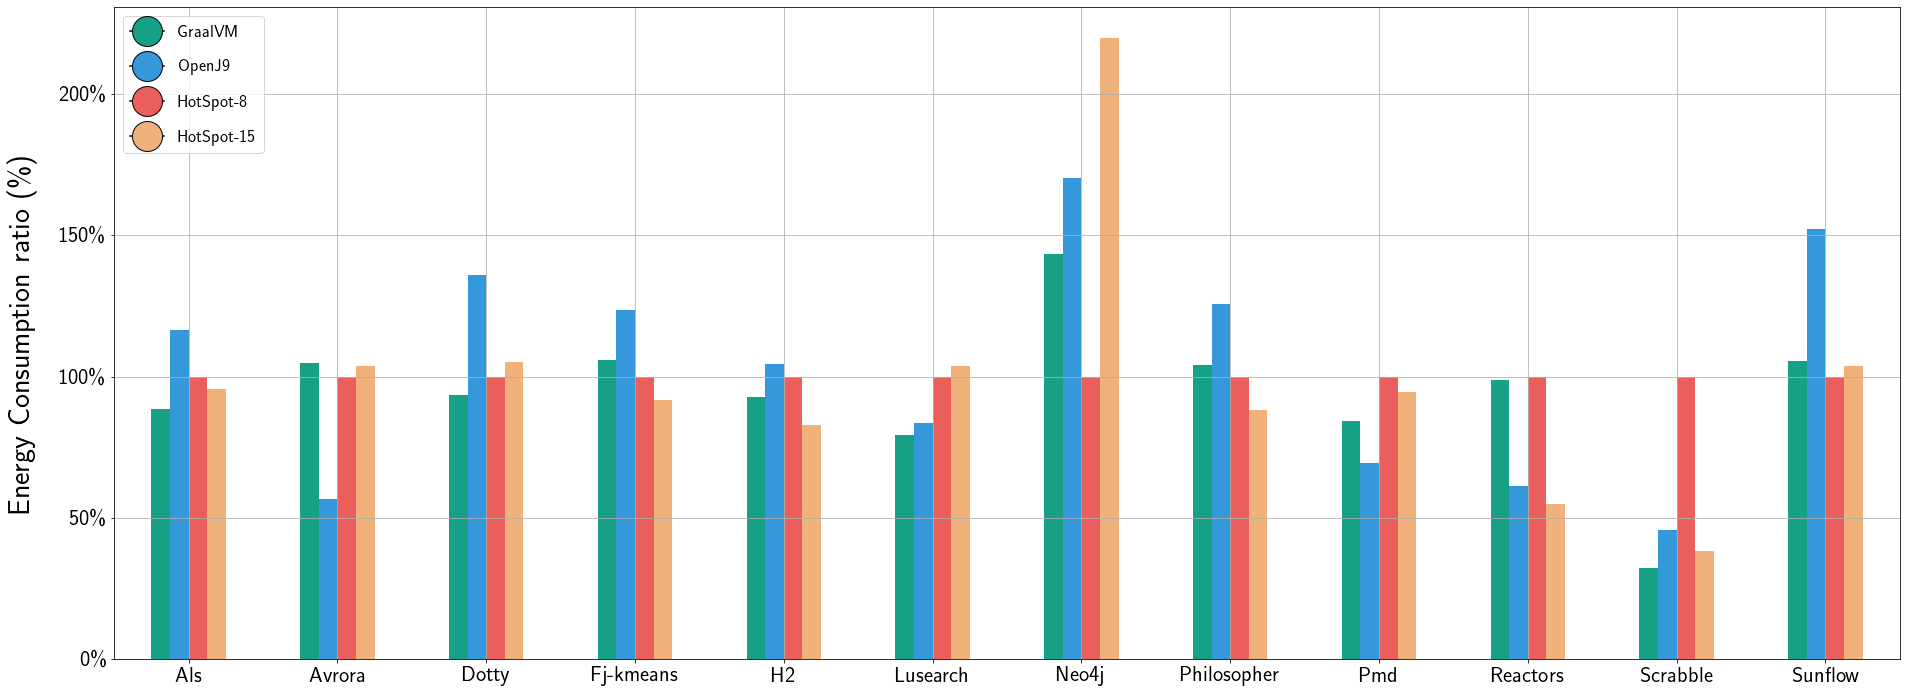

In [32]:
def bar_plot_energy(df,machine="",save=False):
    title=f"Energy consumption within different JVMs"
    fig, axes = plt.subplots(1, 1, figsize=(32, 12))
    y=df.pivot(columns="jvm",index='benchmark', values='energy_pkg')
#     return y
    y["mean"]=y.apply(lambda row: np.mean(row),axis=1)
    y["Graal"]=y.apply(lambda row : row["Graal"]/row["OpenJDK-8"]*100,axis=1)
    y["J9"]=y.apply(lambda row : row["J9"]/row["OpenJDK-8"]*100,axis=1)
    y["OpenJDK-15"]=y.apply(lambda row : row["OPEN"]/row["OpenJDK-8"]*100,axis=1)
    y["OpenJDK-8"]=y.apply(lambda row : row["OpenJDK-8"]/row["OpenJDK-8"]*100,axis=1)
    
    x=y.drop(["mean","OPEN"],axis=1) 
    fig= x.plot.bar(rot=0,ax=axes,color={"J9":"#3498DB","Graal":"#16A085","OpenJDK-15":"#F0B27A","OpenJDK-8":"#ea5f5b"},grid=True)
    
    fig.set_ylabel(ylabel="Energy Consumption ratio (\%)",labelpad=22,fontsize="30")
    fig.get_figure().suptitle('')
    fig.set_xlabel(xlabel='')
    fig.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    ########## legends 
    
    legends=[
        Line2D([0], [0], marker='o', color='k', label='GraalVM',
                          markerfacecolor='#16A085', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='OpenJ9',
                          markerfacecolor='#3498DB', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='HotSpot-8',
                          markerfacecolor='#ea5f5b', markersize=30),
        Line2D([0], [0], marker='o', color='k', label='HotSpot-15',
                          markerfacecolor='#F0B27A', markersize=30),
              
#             Line2D([0], [0], marker='o', color='k', label='Others',
#                           markerfacecolor='w', markersize=30)
            ]
    
    fig.legend(handles=legends, loc='upper left',fontsize='xx-large',labelspacing=1)
    
    ############## inside the boxplots 
#     for i in range(len(fig[0][1]['boxes'])): 
#         color = get_filling_color(fig[0][0].get_xticklabels()[i].get_text())
#         fig[0][1]['boxes'][i].set(color="b",edgecolor='black',facecolor=color,linewidth=1)
#         fig[0][1]['medians'][i].set(color="red",linewidth=0.5)
#         fig[0][1]['whiskers'][i].set(color="black",linewidth=1)
    if save :
        fig.set_title("",fontsize="30",pad=50  )
        plt.savefig(f"bar_plot_all_{machine}-basedon8.pdf",format="pdf")
    else:
        fig.set_title(title,fontsize="30",pad=50  )
        plt.show()
    return fig


x=x.loc[x["mode"]=="Default"]
x=pd.concat([x,open8])
x=x.loc[x["benchmark"]!="lusearch-fix"]
x["benchmark"]=x["benchmark"].apply(lambda x : x.capitalize())
_=bar_plot_energy(x,"chetemi-2-3",True)



In [11]:
show(x)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

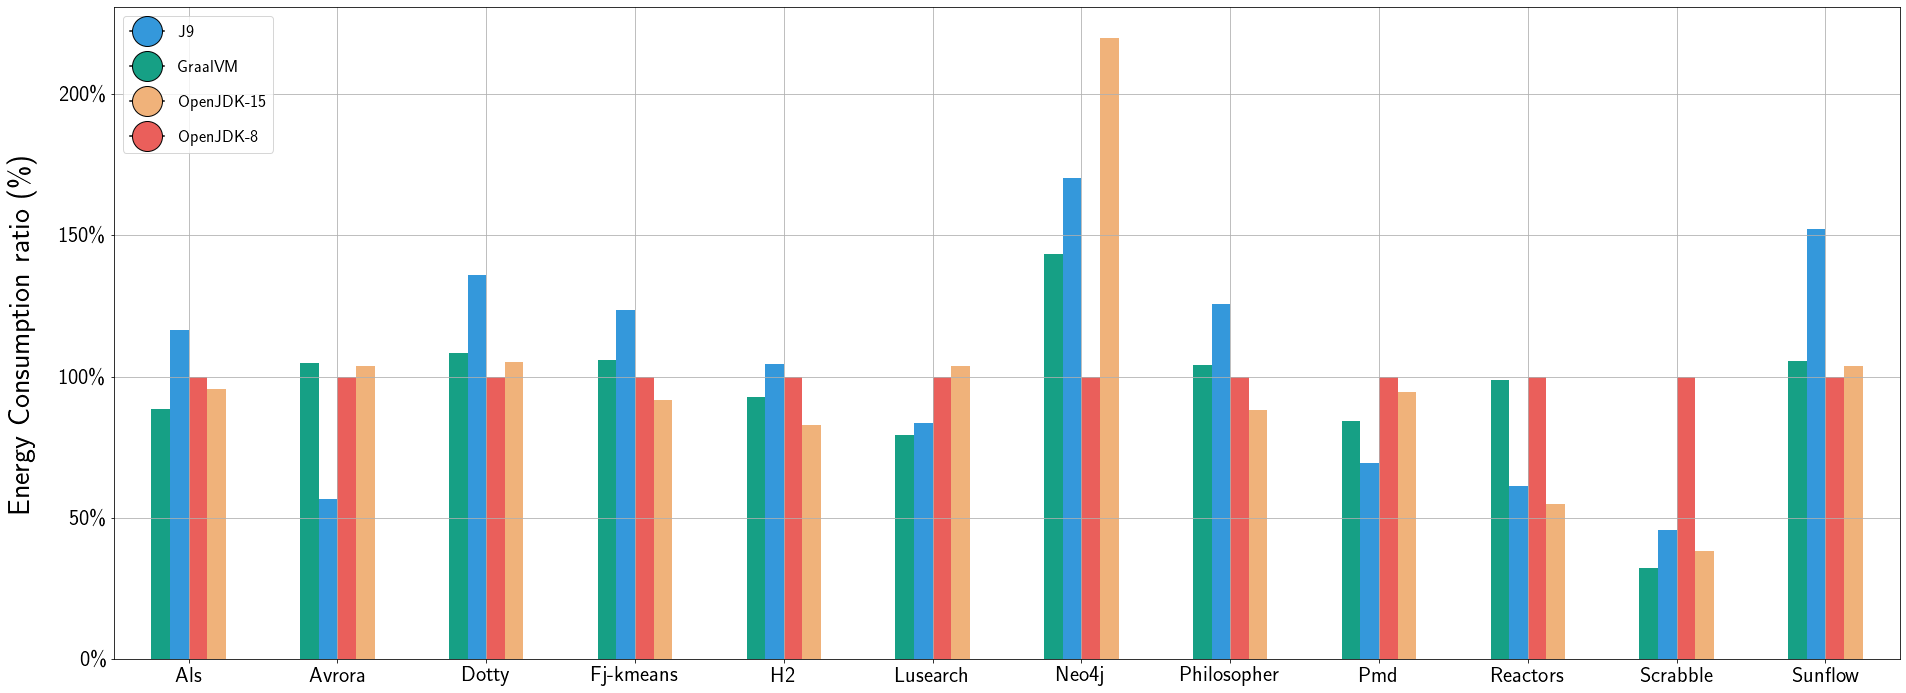

In [17]:
_=bar_plot_energy(y,"chetemi-2-3",True)

In [21]:
zgc=parse_log("report-zgc2-chetemi-3.logs")

In [27]:
zz=zgc.groupby(["mode","benchmark"]).mean()

In [30]:
zz.unstack()["energy_pkg"]

benchmark,als,avrora,dotty,fj-kmeans,h2,lusearch,neo4j,philosopher,pmd,reactors,scrabble,sunflow
mode,,,,,,,,,,,,
Default,11075.722,4099.084,2509.330,3960.5980,1829.822,236.070,5133.0625,81.8500,314.78,11782.075,480.3475,328.65
zgc,11242.440,4092.100,2542.774,7341.9925,2147.690,244.424,2605.4950,94.5375,339.63,12423.830,575.9750,449.00


In [ ]:
,index=True,float_format="%.0f")

In [14]:
y=x.reset_index(drop=True)

In [16]:
y.at[16,"energy_pkg"]=2502.494+80

In [15]:
show(y)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [99]:
x=pd.concat([dacapo,renaissance])
x=x.loc[x["mode"]=="Default"]

y=x.pivot(columns="jvm",index='benchmark', values='energy_pkg')

In [133]:

jit

NameError: name 'jit' is not defined

In [92]:
x=x.reset_index()

In [44]:
dacapo=parse_log(gc_dacapo)

In [52]:
renaissance=parse_log(gc_renaissance)

In [53]:
show(renaissance)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [100]:
x.to_csv("gc-all.csv")

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [54]:
y=pd.concat([dacapo,renaissance])

In [55]:
show(y)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [56]:
show(y.groupby(["jvm","mode","benchmark"]).mean())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['jvm']

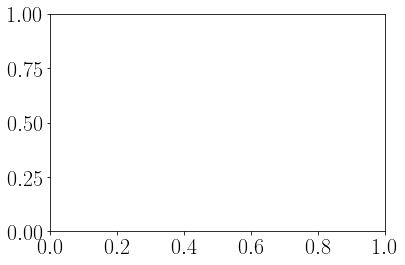

In [32]:
x=pd.concat([dacapo,renaissance])
# pd.options.plotting.backend ='plotly'
x=pd.concat([dacapo,renaissance])
# x=x.reset_index()
x=x[x["mode"]=="Default"]
# fig.show()
for benchmark in x["benchmark"].unique(): 
    fig=x.loc[x["benchmark"]==benchmark].plot.scatter(x="execution_time",y="energy_pkg",color="jvm",title=benchmark)
    fig.show()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['jvm']

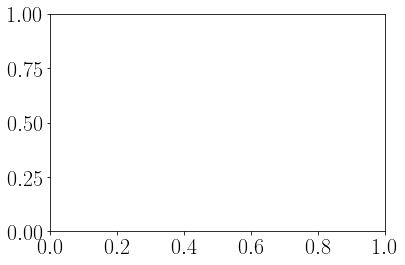

In [30]:
# pd.options.plotting.backend ='plotly'
x=pd.concat([dacapo,renaissance])
# x=x.reset_index()
x=x[x["mode"]=="Default"]
# fig.show()
for benchmark in x["benchmark"].unique(): 
    fig=x.loc[x["benchmark"]==benchmark].plot.scatter(x="execution_time",y="energy_pkg",color="jvm",title=benchmark)
    fig.show()

In [124]:
x.drop(["lusearch-fix","philosopher","fj-kmeans"],axis=1).to_latex(buf="../../table-gc-all.tex",index=True,float_format="%.0f")


In [21]:
x.drop(["lusearch-fix","philosopher","fj-kmeans"],axis=1)

NameError: name 'x' is not defined

In [29]:
y=y.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg')

ValueError: Index contains duplicate entries, cannot reshape

In [132]:
y.drop(["lusearch-fix","philosopher"],axis=1).to_latex(buf="../../table-jit-all1.tex",index=True,float_format="%.0f")


In [25]:
y.drop(["lusearch-fix","philosopher"],axis=1)

KeyError: "['lusearch-fix' 'philosopher'] not found in axis"

In [134]:
jit=parse_log(jit_file)
jit=jit.groupby(["jvm","mode","benchmark"]).mean().reset_index()
jit.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg').to_latex(buf="../../table-jit.tex",index=True,float_format="%.2f")
show(jit)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
renaissance

NameError: name 'renaissance' is not defined

In [35]:
jit=x.groupby(["jvm","mode","benchmark"]).mean().reset_index()
x=jit.pivot(index=["jvm","mode"], columns='benchmark', values='energy_pkg')

In [36]:
show(x)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
epslion=parse_log("report-gcepsilon-chetemi-3.logs")

In [7]:
show(epslion)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [11]:
show(epslion.groupby(["benchmark","mode"]).mean())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
show(epslion.groupby(["benchmark","mode"]).std())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…